In [1]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
  adapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/ (12.12.2021)
  further sources:
  https://pythonprogramming.net/autoencoders-tutorial/ (15.12.2021)
  https://www.geeksforgeeks.org/role-of-kl-divergence-in-variational-autoencoders/ (15.12.2021)
  http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/ (16.12.2021)
  https://jaketae.github.io/study/vae/ (16.12.2021)
  https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb (16.12.2021)
  https://www.tensorflow.org/tutorials/generative/cvae (16.12.2021)

'''

import keras
import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [2]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

In [3]:
tf.compat.v1.disable_eager_execution()

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [4]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [5]:
# # =================
# # Encoder
# # =================

# Definition
i = Input(shape=input_shape, name='encoder_input')
x = Flatten()(i)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation='relu')(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps


# Use reparameterization trick to ....??
z = Lambda(sample_z, output_shape=(latent_dim,), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['encoder_input[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                            

In [6]:
# =================
# Decoder
# =================

# Definition
d_i = Input(shape=(latent_dim,), name='decoder_input')
x = keras.layers.Dense(256, activation="relu")(d_i)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(784, activation="relu")(x)
o = keras.layers.Reshape(input_shape)(x)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 256)               768       
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


In [7]:
# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               267780    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         268048    
                                                                 
Total params: 535,828
Trainable params: 535,828
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [9]:
# Compile VAE
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=opt, loss=kl_reconstruction_loss)

# Train autoencoder
history = vae.fit(input_train, input_train, epochs=no_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47488/48000 [============================>.] - ETA: 0s - loss: 298.8901

c:\users\sonja krafft\documents\uni\mlcms\exercise3\venv\documents\mlcms\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 5s 112us/sample - loss: 298.5101 - val_loss: 267.1556
Epoch 2/100
48000/48000 [==============================] - 4s 91us/sample - loss: 260.8663 - val_loss: 249.6236
Epoch 3/100
48000/48000 [==============================] - 4s 88us/sample - loss: 248.4754 - val_loss: 247.0195
Epoch 4/100
48000/48000 [==============================] - 4s 88us/sample - loss: 246.6347 - val_loss: 244.0352
Epoch 5/100
48000/48000 [==============================] - 4s 87us/sample - loss: 242.3939 - val_loss: 231.4344
Epoch 6/100
48000/48000 [==============================] - 4s 85us/sample - loss: 229.4491 - val_loss: 223.4632
Epoch 7/100
48000/48000 [==============================] - 5s 95us/sample - loss: 229.5810 - val_loss: 225.0714
Epoch 8/100
48000/48000 [==============================] - 4s 84us/sample - loss: 225.3188 - val_loss: 235.1586
Epoch 9/100
48000/48000 [==============================] - 4s 85us/sample - loss: 227.8221 - val_loss: 222.7764
Epo

loss = 197

### Subtask 1: What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood?

### Subtask 2: What might the reason if we obtain good reconstructed but bad generated digits?

??
When the reconstruction works well but the generation does not, the VAE remembers the training data too well and generalizes bad. The model overfits the given data.

### Subtask 3: Train the VAE

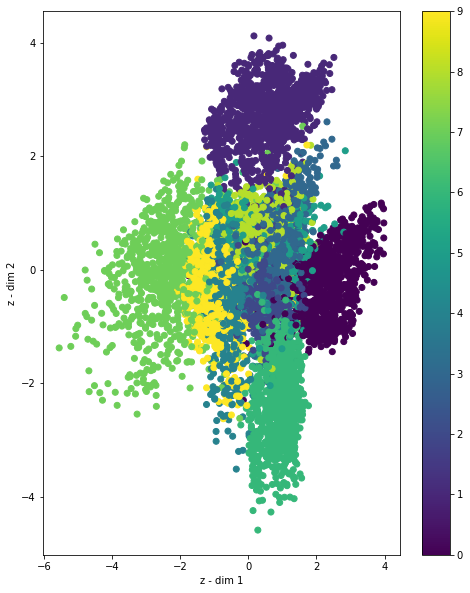

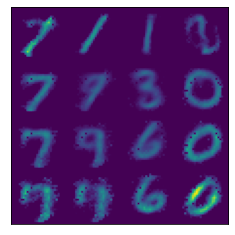

In [15]:
# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
# (François Chollet).
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()


def viz_decoded(encoder, decoder, data):
    num_samples = 4
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
            j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(4, 4))

    plt.xticks([])
    plt.yticks([])

    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure)
    plt.show()


# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

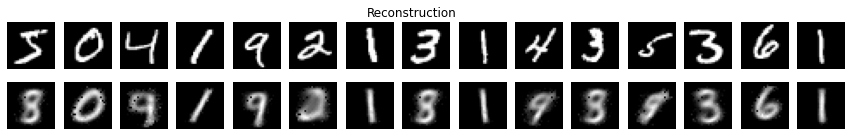

In [33]:
def vis_reconstruction(num_samples):
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples, 2))
    fig.suptitle('Reconstruction')
    for i in range(num_samples):
        axs[0][i].imshow(input_train[i], cmap="gray")
        axs[0][i].axis('off')
    for i in range(num_samples):
        out = vae.predict([input_train[i].reshape(-1, 28, 28, 1) ])[0]
        axs[1][i].imshow(out, cmap="gray")
        axs[1][i].axis('off')


vis_reconstruction(15)

### Subtask 4: Plot the loss curve

In [10]:
#print(vae.history.history)
loss_history = history.history['val_loss']
print(loss_history)

[267.15558219401044, 249.62357694498698, 247.01946464029947, 244.03515393066405, 231.43438997395833, 223.46323498535156, 225.07140592447917, 235.15857425944012, 222.7763633219401, 224.03727071126303, 222.88995170084635, 216.91123864746095, 233.642370320638, 220.91923571777343, 217.3563349609375, 216.80147204589844, 215.89898860677084, 216.51215580240884, 214.5619765625, 212.7324061279297, 212.0465772705078, 218.97976216634115, 220.36484248860677, 212.2255489501953, 213.00792240397135, 212.41033837890626, 212.43197819010416, 211.6367870686849, 210.40673799641928, 217.84522391764324, 211.54825911458335, 210.96841743977865, 209.92357242838543, 212.0081954752604, 216.26100325520832, 205.55965970865884, 206.3755997314453, 211.46982291666666, 212.62018717447916, 207.79056880696615, 200.989068359375, 206.05050329589844, 203.7588741455078, 200.15278356933592, 214.8936991780599, 214.21930904134115, 202.1964845784505, 200.33720568847656, 199.6900545247396, 200.5095965576172, 199.56468501790366, 

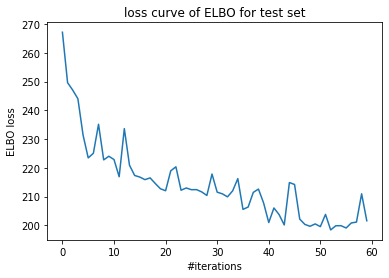

In [11]:
plt.plot(loss_history)
plt.title("loss curve of ELBO for test set")
plt.xlabel('#iterations')
plt.ylabel('ELBO loss')
plt.show()

### Subtask 5: VAE with latent_dim=32

change latent_dim=32 and rerun

Results: